In [151]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain, combinations
from functools import partial
# import statsmodels.api as sm

%matplotlib inline
%config Completer.use_jedi = False

In [152]:
plt.rcParams["axes.labelweight"] = "bold"

sns.set_palette("deep")
sns.set_style("white")
sns.set_context("paper", font_scale = 2.0, rc={"grid.linewidth": 2.5, 'fontweight':'bold'})

plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

**Load GPU failure data**

In [153]:
FAILURES = '/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_gpu_failures/gpu_failures.csv'
BUS = '/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_gpu_failures/gpu_bus_ids.csv'
NODE = 'hostname'
XID = 'xid'
MSG = 'message'
GPU = 'GPU'
PCI = 'PCI'
TIME = 'timestamp'

failures = pd.read_csv(FAILURES)[[TIME, NODE, XID, MSG]]

**Extract PCI address**

In [154]:
failures[PCI] = failures[MSG].str[16:26]

**Extract spatial features**

In [155]:
# Remove data for login and batch nodes because of ambiguous location.
failures = failures[~failures[NODE].str.startswith('login') & ~failures[NODE].str.startswith('batch')]

In [156]:
# Extract row (1-8) and row offset.
row_by_label = {label: row + 1 for row, label in enumerate('abcdefgh')}
failures['row'] = failures[NODE].str[0].map(row_by_label.get)
# Extract rack (1-37, 50) and rack offset.
failures['rack'] = failures[NODE].str[1:3].astype(int)
# Extract height (1-18).
failures['height'] = failures[NODE].str[4:].astype(int)

In [158]:
xid_names = {
    31: 'Memory page fault', 13: 'Graphics engine exception', 43: 'Stopped processing', 74: 'NVLINK error',
    63: 'Page retirement event', 64: 'Page retirement failure', 48: 'Double-bit error', 45: 'Preemptive cleanup',
    61: 'Internal microcontroller warning', 44: 'Graphics engine fault', 79: 'Fallen off the bus', 62: 'Internal microcontroller halt',
    38: 'Driver firmware error', 32: 'Corrupted push buffer stream', 12: 'Driver error handling exception', 69: 'Graphics engine class error'}
xids = [64, 48, 45, 61, 44, 63, 74, 79, 62, 38, 32, 12, 69]

In [159]:
xid_counts = failures.groupby(XID)[XID].count()
xids = xid_counts[xid_counts >= 30].index.values

**Assign GPU order**

In [160]:
# Form PCI address list for each node.
pcis = failures.groupby(NODE)[PCI].unique().apply(
    lambda x: ' '.join(s[2:-3] for s in sorted(x)))
pcis_counts = pcis.value_counts()

correct_pcis = pcis_counts.index[0] # 4500 nodes probably have it right

# Select nodes without weird PCI addresses.
good_nodes = pcis[pcis == correct_pcis].index
len(good_nodes)

04:04 04:05 04:06 35:03 35:04 35:05          4507
04:04 04:05 04:06 35:03 35:04 35:05 35:06      59
04:04 04:05 04:06 35:03 35:05                  14
04:04 04:05 04:06 34:05 35:03 35:04 35:05       8
04:03 04:04 04:05 04:06 35:03 35:04 35:05       7
Name: PCI, dtype: int64


4507

In [161]:
correct_pci_list = ['0004:04:00', '0004:05:00', '0004:06:00', '0035:03:00', '0035:04:00', '0035:05:00']
pci2gpu = {pci: i for i, pci in enumerate(correct_pci_list)}

In [166]:
failures_pci = failures[failures[NODE].isin(good_nodes)].assign(GPU=lambda x: x[PCI].apply(pci2gpu.get))

**Plot**

In [167]:
df = failures_pci[failures_pci[XID].isin(xids)].copy()

XID_NAME = 'type'
df[XID_NAME] = df[XID].apply(xid_names.get)

/ccs/home/olesv/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


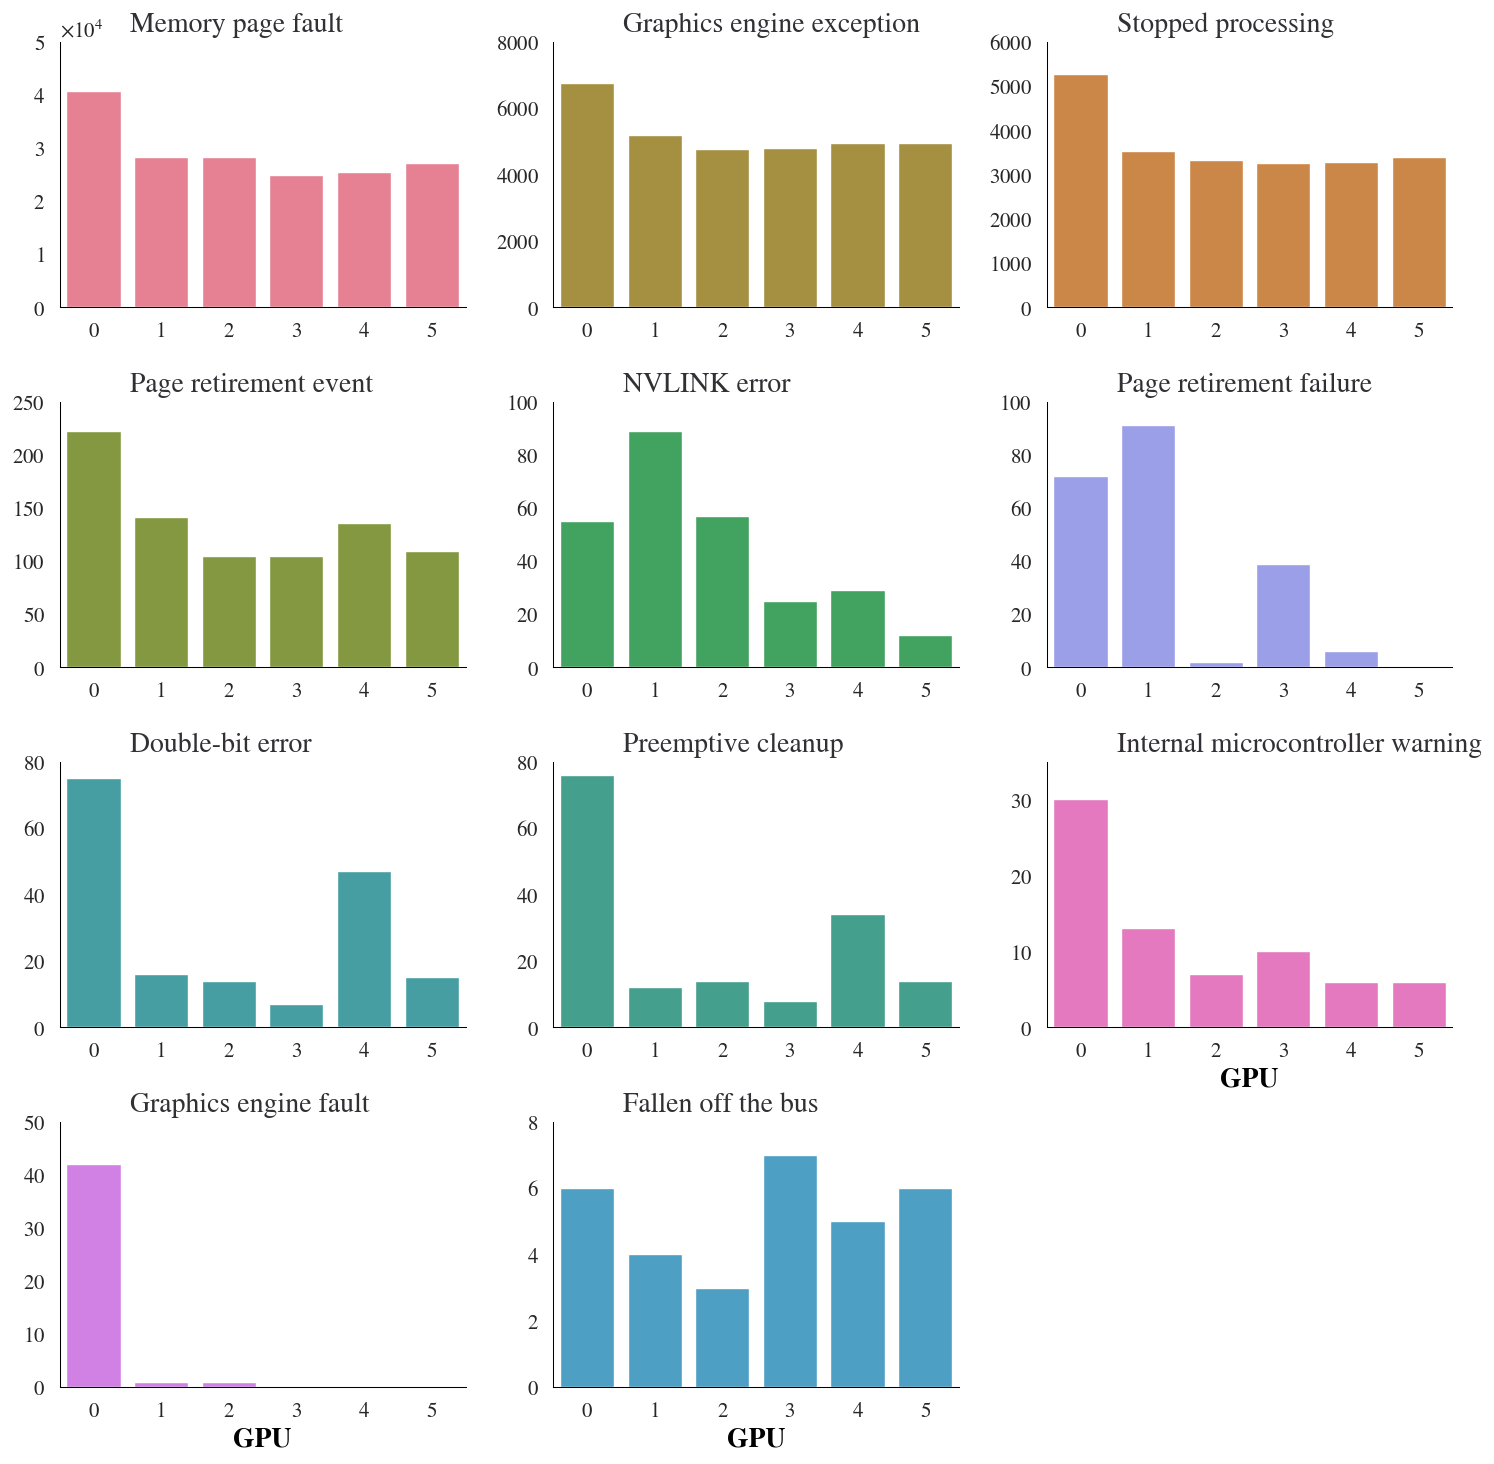

In [169]:
df = df[df[NODE] != 'f26n07']
xid_order = df[XID].value_counts().sort_values(ascending=False).index.map(xid_names.get)
g = sns.FacetGrid(
    df, col=XID_NAME, hue=XID_NAME, col_order=xid_order,
    col_wrap=3, margin_titles=True, sharey=False, **width_height(columns=2, rows=2))
min_gpu = df[GPU].min()
max_gpu = df[GPU].max()
n_gpus = max_gpu - min_gpu + 1
g.map(sns.countplot, GPU)
g.set_titles(' '*10 + '{col_name}')
for ax in g.axes:
    ax.tick_params(labelbottom=True)


/ccs/home/olesv/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


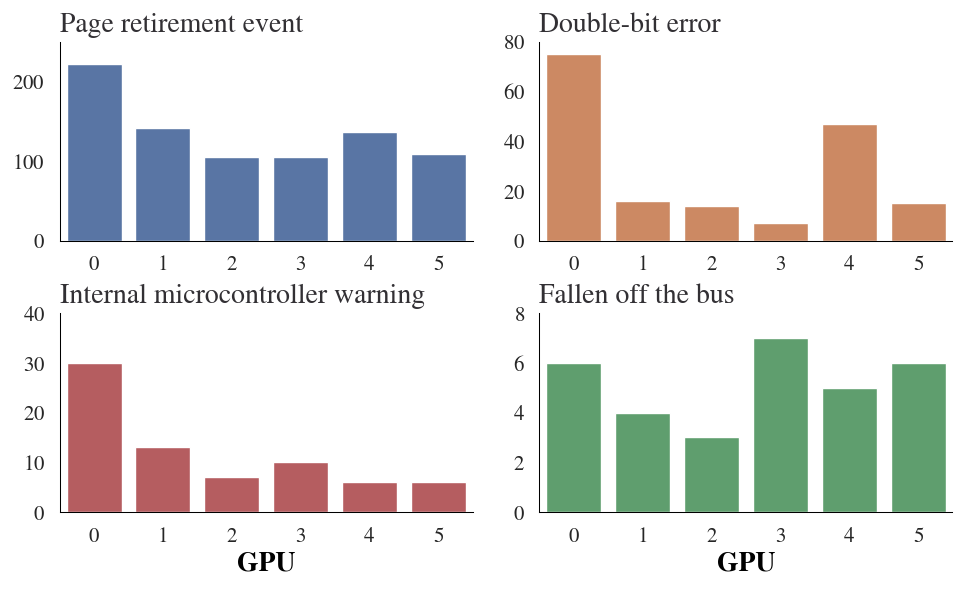

In [170]:
df_plot = df[df[XID].isin([63, 48, 61, 79])]
xid_order_plot = df_plot[XID].value_counts().sort_values(ascending=False).index.map(xid_names.get)
g = sns.FacetGrid(
    df_plot, col=XID_NAME, hue=XID_NAME, col_order=xid_order_plot,
    col_wrap=2, margin_titles=True, sharey=False, **width_height(height=5, columns=2, rows=2))
min_gpu = df_plot[GPU].min()
max_gpu = df_plot[GPU].max()
n_gpus = max_gpu - min_gpu + 1
g.map(sns.countplot, GPU)
g.set_titles('{col_name}')
for ax in g.axes:
    ax.tick_params(labelbottom=True)

In [150]:
g.savefig('../plots/failures_by_gpu.pdf')

**NVLINK error breakdown**

In [35]:
LINK = 'link'
nvlink = failures_pci[failures_pci[XID] == 74].copy()
nvlink[LINK] = nvlink[MSG].str.extract(r'link (\d)')

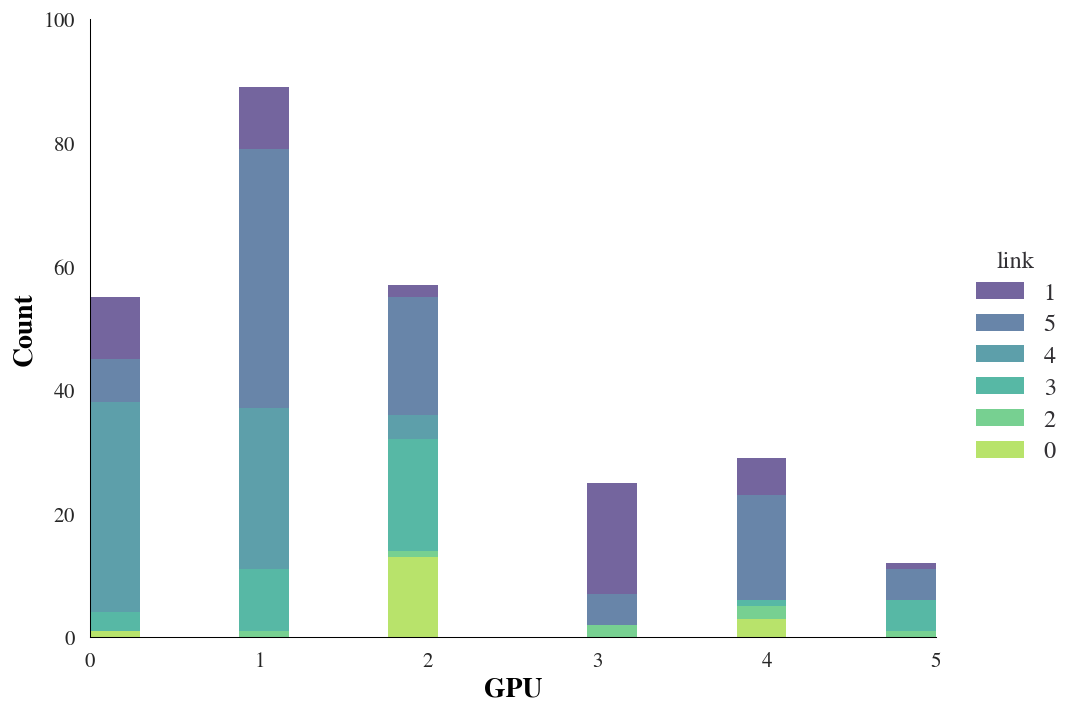

In [36]:
nvlink = nvlink[nvlink[NODE] != 'f26n07']
# sns.countplot(data=nvlink, x=GPU, hue=LINK, palette='viridis', lw=0)
g = sns.displot(data=nvlink, x=GPU, hue=LINK, multiple='stack', palette='viridis', lw=0, **width_height())
ax = g.axes[0][0]
ax.set_xlim(0, 5)
# ax.set_xticks(range(6))
g.savefig('../plots/nvlink.pdf')

**Plot distribution by row, rack, and height**

In [37]:
xid_counts = failures.groupby(XID)[XID].count()
xids = xid_counts[xid_counts >= 50].index.values

df = failures_pci[failures_pci[XID].isin(xids)].copy()

XID_NAME = 'type'
df[XID_NAME] = df[XID].apply(xid_names.get)
df = df[df[NODE] != 'f26n07']

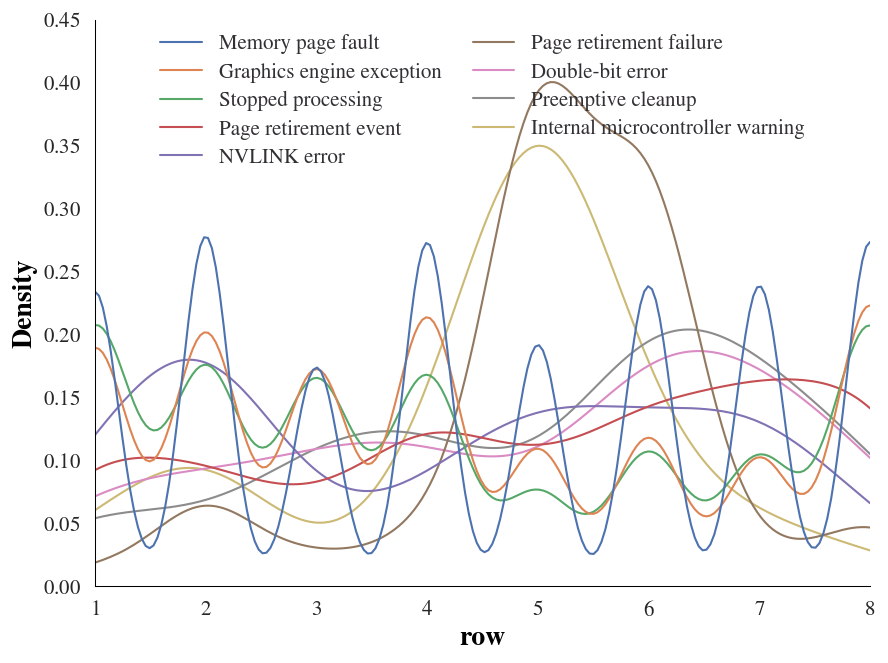

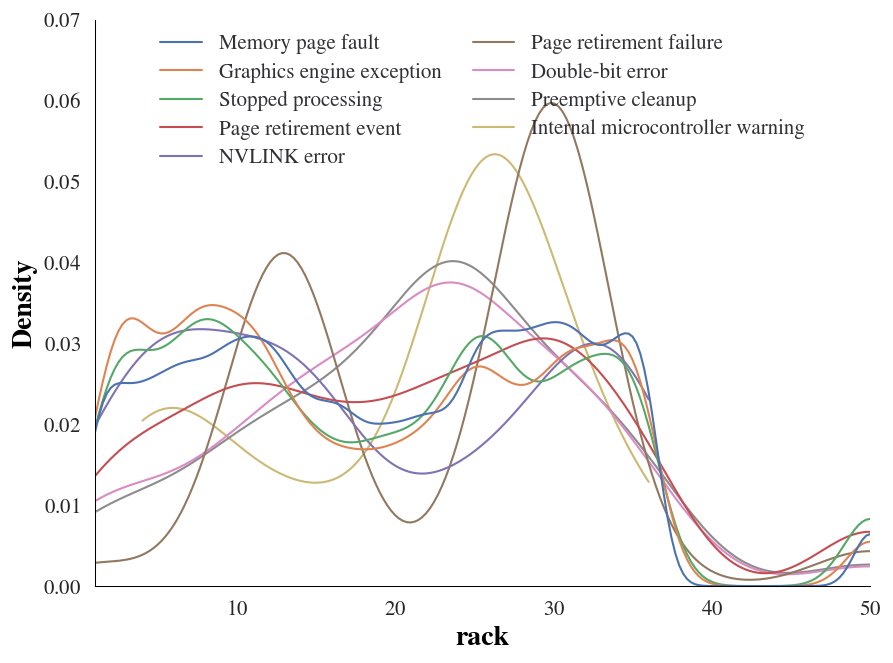

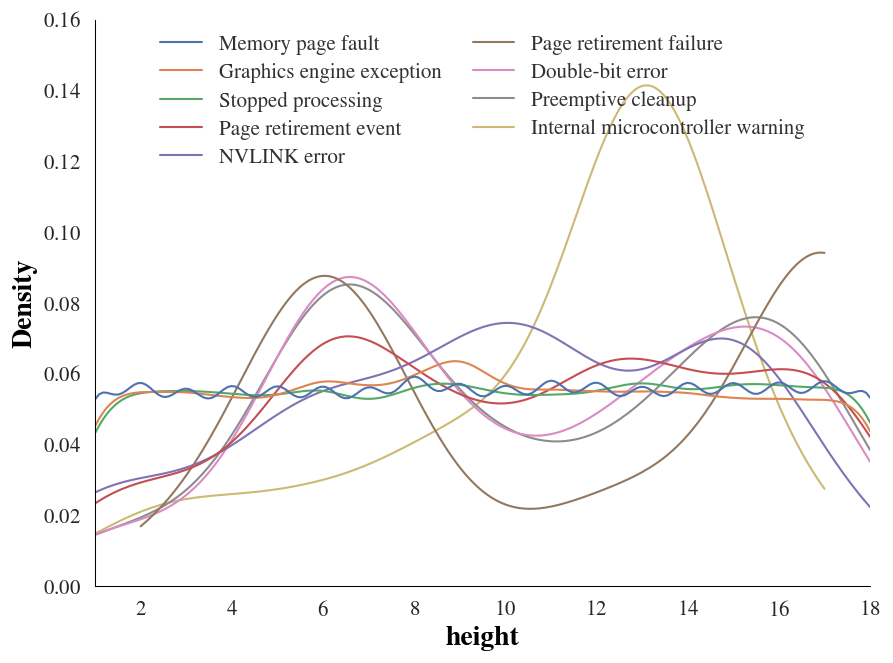

<Figure size 1000x750 with 0 Axes>

In [61]:
xid_order = df[XID].value_counts().sort_values(ascending=False).index.map(xid_names.get)
for var in ['row', 'rack', 'height']:
    # g = sns.FacetGrid(df, col=XID_NAME, col_wrap=2, **width_height(columns=2, rows=2))
    # g.map(sns.kdeplot, 'height')
    ax = sns.kdeplot(data=df, x=var, hue=XID_NAME, cut=0, common_norm=False, hue_order=xid_order)
    ax.set_xlim(df[var].min(), df[var].max())
    plt.legend(ax.get_legend().get_lines(), xid_order, ncol=2, title='', frameon=False, fontsize=12, loc='upper center')
    plt.show()
    plt.savefig(f'../plots/gpu_failures_by_{var}.pdf')

In [70]:
failures[failures[XID] == 48].groupby([XID, NODE])[NODE].count().sort_values()
# xid_names[48]

xid  hostname
48   a04n16       1
     d22n08       1
     h34n13       1
     d28n14       1
     d30n18       1
                 ..
     g36n06      10
     h16n14      11
     d11n06      12
     g20n07      14
     f24n16      33
Name: hostname, Length: 63, dtype: int64